# **Melanoma Cancer Detection using Convolutional Neural Network**

**Problem Statement:**  To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Data:** Dataset can be downloaded from here https://drive.google.com/file/d/1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs/view?usp=sharing

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion


## **Project Pipeline:**

* Data Reading/Data Understanding → Defining the path for train and test images
* Dataset Creation→ Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.
* Dataset visualisation → Create a code to visualize one instance of all the nine classes present in the dataset
* Model Building & training :
    * Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
    * Choose an appropriate optimiser and loss function for model training
    * Train the model for ~20 epochs
    * Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.
    * Chose an appropriate data augmentation strategy to resolve underfitting/overfitting
* Model Building & training on the augmented data :
    * Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
    * Choose an appropriate optimiser and loss function for model training
    * Train the model for ~20 epochs
    * Write your findings after the model fit, see if the earlier issue is resolved or not?
* Class distribution: Examine the current class distribution in the training dataset
    * Which class has the least number of samples?
    * Which classes dominate the data in terms of the proportionate number of samples?
* Handling class imbalances: Rectify class imbalances present in the training dataset with Augmentor library.
* Model Building & training on the rectified class imbalance data :
    * Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
    * Choose an appropriate optimiser and loss function for model training
    * Train the model for ~30 epochs
    * Write your findings after the model fit, see if the issues are resolved or not?


## 1. Importing Skin Cancer Data

In [ ]:
# Importing neccessary modules and packages
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred',seed=123,batch_size=batch_size,image_size=(img_height,img_width),validation_split=0.2,subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred',seed=123,batch_size=batch_size,image_size=(img_height,img_width),validation_split=0.2,subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 2. Visualize the data

visualize one instance of all the nine classes present in the dataset

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

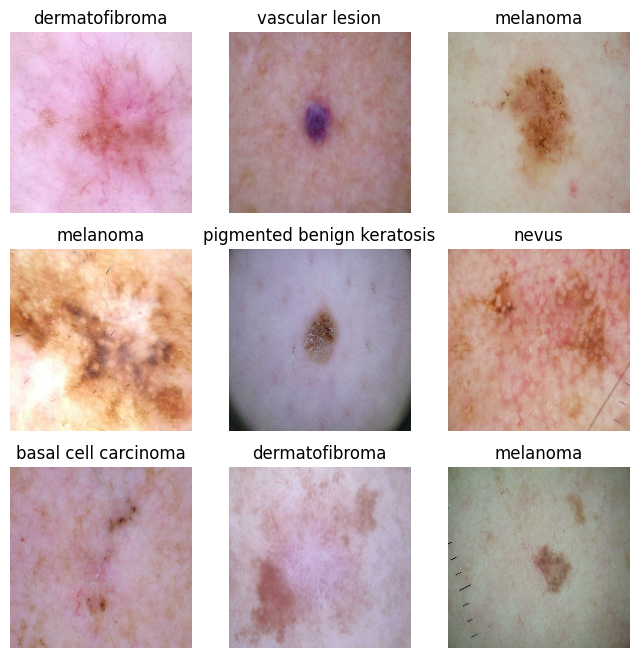

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for img, labl in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[labl[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Create the Model

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
num_classes = 9 # As target class has 9 labels

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 3.1 compile the model

Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
#loss: Sparse Categorical Crossentropy Calculates the crossentropy loss between labels and predictions.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### 3.2 Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 788s 950ms/step - loss: 1.9870 - accuracy: 0.2591 - val_loss: 1.5581 - val_accuracy: 0.4128
Epoch 2/20
169/169 [==============================] - 2s 11ms/step - loss: 1.4444 - accuracy: 0.4523 - val_loss: 1.3434 - val_accuracy: 0.4848
Epoch 3/20
169/169 [==============================] - 2s 10ms/step - loss: 1.2143 - accuracy: 0.5504 - val_loss: 1.2137 - val_accuracy: 0.5442
Epoch 4/20
169/169 [==============================] - 2s 10ms/step - loss: 1.0686 - accuracy: 0.6042 - val_loss: 1.0651 - val_accuracy: 0.6073
Epoch 5/20
169/169 [==============================] - 2s 11ms/step - loss: 0.8972 - accuracy: 0.6682 - val_loss: 0.9739 - val_accuracy: 0.6652
Epoch 6/20
169/169 [==============================] - 2s 12ms/step - loss: 0.7699 - accuracy: 0.7187 - val_loss: 1.0028 - val_accuracy: 0.6808
Epoch 7/20
169/169 [==============================] - 2s 11ms/step - loss: 0.6074 - accuracy: 0.7869 - val_loss: 0.7886 - val_accuracy: 0.7

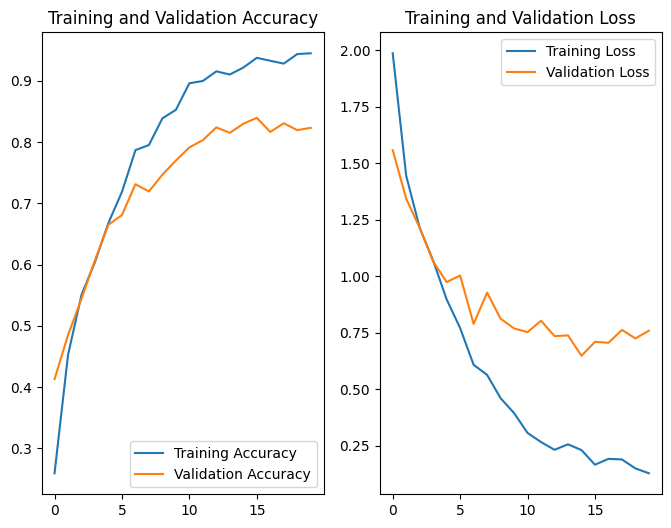

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

The above model is clearly the case of overfitting and the model doesn't seem to be learning anything from the dataset.
   1. Training accuracy is very high (~86%), while validation accuracy is around 50%.
   2. The loss on the training set decreases after each epoch, but in the case of the validation set, it climbs back again after the 10th epoch.

Instead of generalizing and learning real features and general relationships, the model memorized the data

The above observations confirm the case of overfitting. To mitigate overfitting augmentation technique will be used. Since the training data available is less, we will generate new samples by slightly modifying the existing training data (for eg. flipping the image horizontally/vertically, slightly rotating the image etc) and use them for training the model as well.

In [ ]:
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

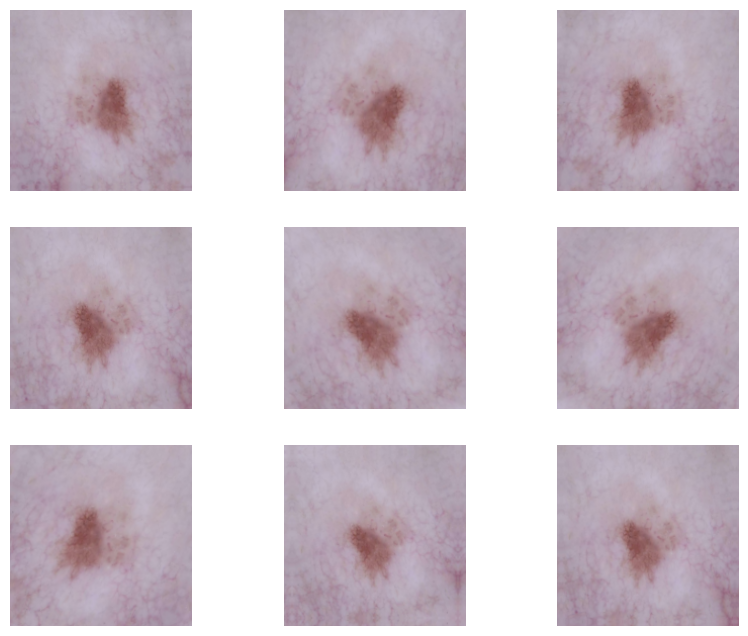

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 4. Create the model, compile and train the model on augmented data

In [ ]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

### 4.1 Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### 4.2 Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

### 4.3 Visualize the results

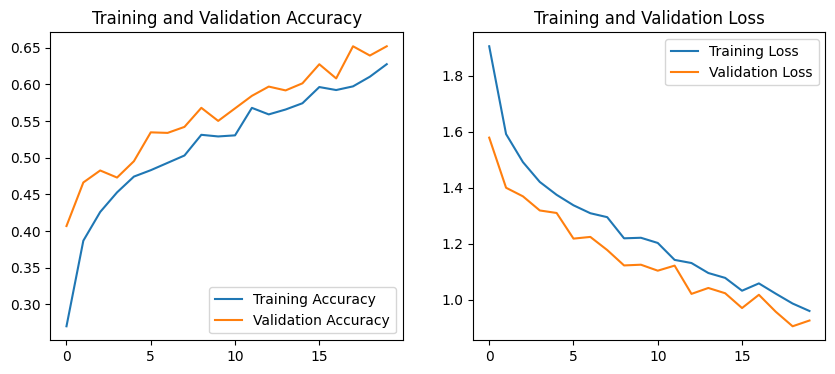

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Comment:

* With the help of augmented data, the problem of overfitting is mitigated.
* Training and validation accuracy of the above model are in the same range.
* The model is performing poorly both on training data and validation data- i.e. the model is underfitting now.

### 4.4 Find the distribution of classes in the training dataset.

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

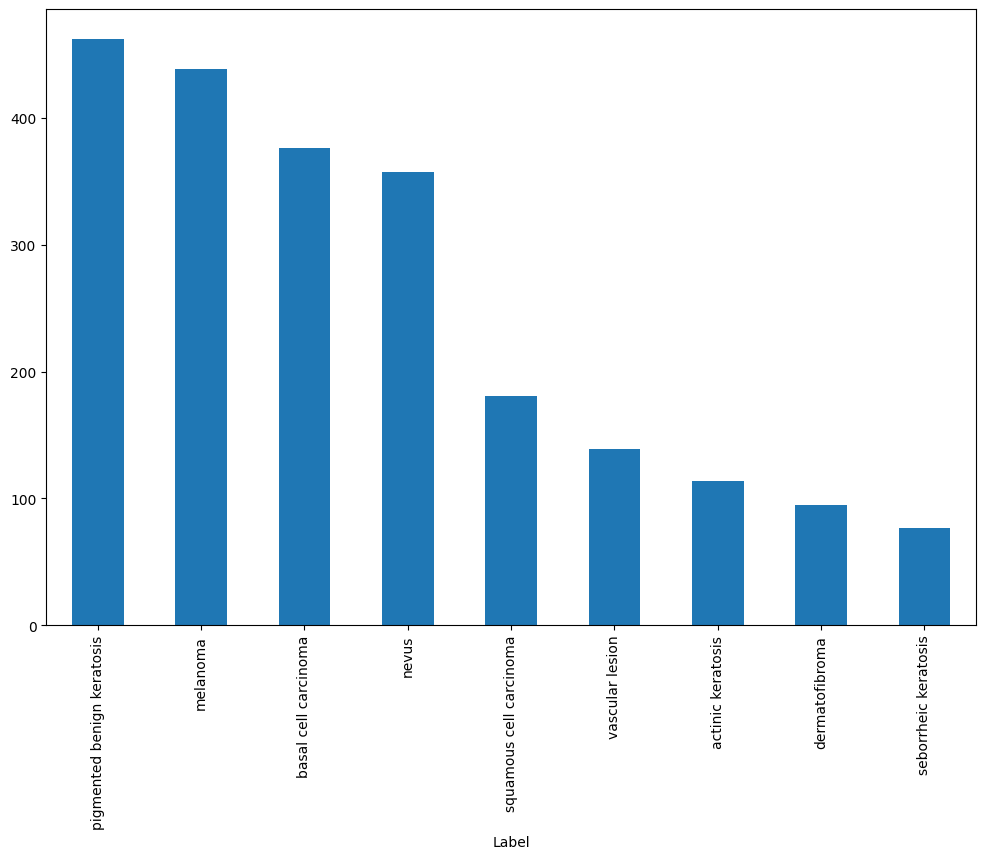

In [ ]:
plt.figure(figsize=(12,8))
original_df['Label'].value_counts().plot.bar()
plt.show()

**Todo:** Write your findings here:
- Which class has the least number of samples?
->seborrheic keratosis

- Which classes dominate the data in terms proportionate number of samples?
->pigmented benign keratosis

**Todo:** Rectify the class imbalance

**Context:** You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

## 5. Rectify the class imbalance using Augmentor package

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:


* Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.
* Define a number of operations to perform on this data set using your Pipeline object.
* Execute these operations by calling the `Pipeline’s` `sample()` method.

In [ ]:
path_to_training_dataset=str(data_dir_train)+'/'#'./Skin cancer ISIC The International Skin Imaging Collaboration/Train/'#"To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9612157DF0>: 100%|██████████| 500/500 [00:20<00:00, 24.04 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D966814F100>: 100%|██████████| 500/500 [00:21<00:00, 22.99 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D96FDCAEF80>: 100%|██████████| 500/500 [00:19<00:00, 26.28 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D96FCEB2590>: 100%|██████████| 500/500 [01:27<00:00,  5.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7D9650103B50>: 100%|██████████| 500/500 [01:02<00:00,  8.02 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D95FA121090>: 100%|██████████| 500/500 [00:22<00:00, 21.98 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D966864E170>: 100%|██████████| 500/500 [00:40<00:00, 12.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D965011F220>: 100%|██████████| 500/500 [00:19<00:00, 25.91 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9650078FD0>: 100%|██████████| 500/500 [00:20<00:00, 24.68 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

12039


### 5.1 Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:2]

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031257.jpg_90ace2cf-f775-4980-b728-5e9a8407861a.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029248.jpg_fae5b884-6d35-4c38-b648-ab93705782e4.jpg']

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:2]

['dermatofibroma', 'dermatofibroma']

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df_2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df_2.shape

(12039, 2)

In [ ]:
original_df.shape

(2239, 2)

In [ ]:
new_df=pd.concat([original_df,df_2])

In [ ]:
new_df.shape

(14278, 2)

In [ ]:
new_df.head()

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
1,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
2,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
3,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
4,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma


In [ ]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
actinic keratosis             1614
dermatofibroma                1595
squamous cell carcinoma       1181
vascular lesion               1139
seborrheic keratosis          1116
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### 5.2 Train the model on the data created using Augmentor

batch_size = 32
img_height = 180
img_width = 180

 **Todo:** Create a training dataset

In [ ]:
data_dir_train=data_dir_train#"Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14278 files belonging to 9 classes.
Using 11423 files for training.


**Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14278 files belonging to 9 classes.
Using 2855 files for validation.


### 5.3 Create your model (make sure to include normalization)

In [ ]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

**Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Todo:** Train your model

In [ ]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/50
357/357 [==============================] - 85s 223ms/step - loss: 1.8325 - accuracy: 0.2903 - val_loss: 1.4993 - val_accuracy: 0.4294
Epoch 2/50
357/357 [==============================] - 76s 210ms/step - loss: 1.4720 - accuracy: 0.4352 - val_loss: 1.3794 - val_accuracy: 0.4609
Epoch 3/50
357/357 [==============================] - 81s 222ms/step - loss: 1.3509 - accuracy: 0.4854 - val_loss: 1.3587 - val_accuracy: 0.4932
Epoch 4/50
357/357 [==============================] - 82s 227ms/step - loss: 1.2871 - accuracy: 0.5123 - val_loss: 1.2534 - val_accuracy: 0.5170
Epoch 5/50
357/357 [==============================] - 84s 232ms/step - loss: 1.2119 - accuracy: 0.5344 - val_loss: 1.1484 - val_accuracy: 0.5618
Epoch 6/50
357/357 [==============================] - 87s 239ms/step - loss: 1.1358 - accuracy: 0.5740 - val_loss: 1.1126 - val_accuracy: 0.5947
Epoch 7/50
357/357 [==============================] - 76s 209ms/step - loss: 1.0829 - accuracy: 0.5931 - val_loss: 0.9254 - val_ac

Text(0.5, 1.0, 'Training & Validation Loss')

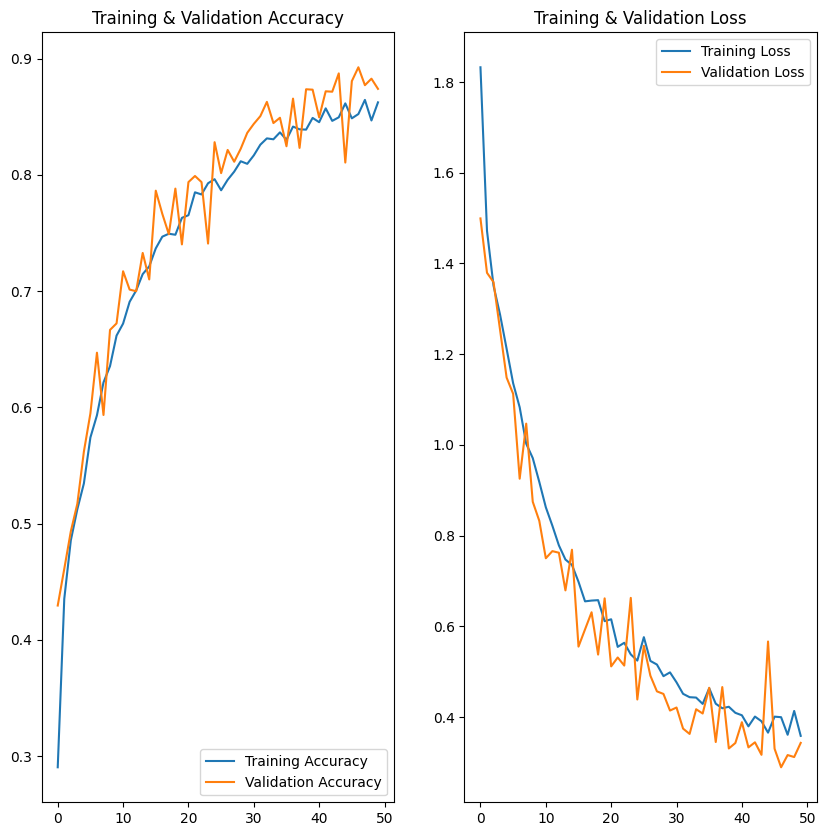

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training & Validation Loss')

**Findings:**

* Accuracy on train set is ~86%
* Accuracy on validation set is ~87%

In [ ]:
#num_classes = 9
#model = Sequential([
  #data_augmentation,
  #layers.Rescaling(1./255),
  #layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.BatchNormalization(),
  #layers.Dropout(0.25),
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.BatchNormalization(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  #layers.Flatten(),
  #layers.Dense(128, activation='relu'),
  #layers.Dropout(0.3),
  #layers.Dense(num_classes)
#])

In [ ]:
# model compilation

#model.compile(optimizer="adam",loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])


In [ ]:
#model design

#model.summary()

In [ ]:
# run the model to fit train datapoint and check accuracy on validation dataset

## Your code goes here, use 50 epochs.
#epochs = 50
#history = model.fit(
  #train_ds,
  #validation_data=val_ds,
  #epochs=epochs
#)# your model fit code

##  6. Analysis on Test Data

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 118 files belonging to 9 classes.


In [ ]:
loss , accuracy = model.evaluate(test_ds)

4/4 [==============================] - 22s 39ms/step - loss: 6.8844 - accuracy: 0.4661


In [ ]:
print("Accuracy on test data ", accuracy)

Accuracy on test data  0.4661017060279846


### 6.1 Prediction on New Test Data

In [ ]:
melanoma_path = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000002.jpg"

img = tf.keras.utils.load_img(
    melanoma_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)

1/1 [==============================] - 0s 207ms/step
tf.Tensor(
[7.5941746e-25 1.2661655e-08 3.2672954e-19 1.7528445e-06 7.6266086e-01
 2.3733740e-01 2.1994309e-20 6.0847988e-17 6.9425873e-26], shape=(9,), dtype=float32)


In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(test_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to nevus with a 76.27 percent confidence.


**Findings:**
* Accuracy on the test set is low compared to train set
* There might be a possibility of overfitting.